In [1]:
from _utils import *

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:80, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:80, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)


2024-09-05 21:42:17.364121: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 21:42:17.407145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Find lower bound and upper bound of PC1 and PC2 data
# 0.01 ensures that structures from PC1 and PC2 sampling are physical
l = 0.0001
u = 1-l

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)


In [4]:
pc1_grid = np.linspace(pc1_l, pc1_u, 5)
pc2_grid = np.linspace(pc2_l, pc2_u, 5)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)  

metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])   

templates_flatten = metastr_from_pca

measurement_error_esc = [calculate_conformational_variance(esc_maps_interp, x.reshape(80, 80))**0.5 for x in templates_flatten]
measurement_error_cnc = [calculate_conformational_variance(cnc_maps_interp, x.reshape(80, 80))**0.5 for x in templates_flatten]

# Generate log prior for metastructures 
lpm = [(logprior(x, num_monomers)).tolist() for x in templates_flatten]

# Generate log likelihood for observations given metastructures 
ll_esc = [[(loglikelihood(y, x, z, num_monomers)).tolist() for x, z in zip(templates_flatten, measurement_error_esc)] for y in esc_maps_interp_flat]
ll_cnc = [[(loglikelihood(y, x, z, num_monomers)).tolist() for x, z in zip(templates_flatten, measurement_error_cnc)] for y in cnc_maps_interp_flat]

N_cnc = cnc_maps_interp_flat.shape[0]
N_esc = esc_maps_interp_flat.shape[0]
M = templates_flatten.shape[0]

In [5]:
lpm

[-24.6440568317639,
 -24.6447444380305,
 -24.706844858328076,
 -4294967296,
 -4294967296,
 -24.182146953224184,
 -24.08946592742329,
 -24.033923351463024,
 -4294967296,
 -4294967296,
 -23.766179363075047,
 -23.56471830164483,
 -23.360403262262555,
 -4294967296,
 -4294967296,
 -4294967296,
 -23.096546751677405,
 -22.7020923010385,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296]

In [6]:
ll_esc

[[-59706.10402765291,
  -58080.24920542154,
  -58728.262302804564,
  -4294967296,
  -4294967296,
  -51664.031741115934,
  -49029.17450371445,
  -48450.00448969066,
  -4294967296,
  -4294967296,
  -48338.166967064106,
  -45597.746285888854,
  -44805.780544306836,
  -4294967296,
  -4294967296,
  -4294967296,
  -51059.39818496886,
  -49510.387866108045,
  -4294967296,
  -4294967296,
  -4294967296,
  -4294967296,
  -4294967296,
  -4294967296,
  -4294967296],
 [-59644.80454364896,
  -56792.98639307688,
  -56003.94123842537,
  -4294967296,
  -4294967296,
  -54106.90935103515,
  -49929.03209608393,
  -47521.50195074712,
  -4294967296,
  -4294967296,
  -53341.91360219314,
  -49695.773546379016,
  -46943.80870822443,
  -4294967296,
  -4294967296,
  -4294967296,
  -55837.412978918706,
  -52419.82452974566,
  -4294967296,
  -4294967296,
  -4294967296,
  -4294967296,
  -4294967296,
  -4294967296,
  -4294967296],
 [-59417.648446451916,
  -58705.15977972747,
  -60413.53666246819,
  -4294967296,
  -4

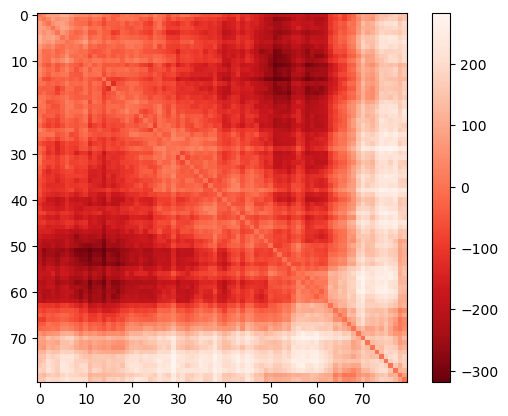

In [6]:
plt.imshow(metastr_from_pca[-1].reshape(80, 80), cmap='Reds_r')
plt.colorbar()

In [12]:
n_components = 4
n_metastructures = 10 

print('Performing PCA')
pca = PCA(n_components=n_components)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=['PC{}'.format(i) for i in range(1, n_components+1)])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC{}'.format(i) for i in range(1, n_components+1)])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find lower bound and upper bound of PC1 and PC2 data
l = 0.01
u = 1-l

pc_min_list = []
pc_max_list = []
for i in range(1, n_components+1):
    pc_min_list.append(all_df['PC{}'.format(i)].quantile(l))
    pc_max_list.append(all_df['PC{}'.format(i)].quantile(u))
    
pc_min_list = np.array(pc_min_list)
pc_max_list = np.array(pc_max_list)

pc_grid_list = []
for i in range(n_components):
    pc_grid_list.append(np.linspace(pc_min_list[i], pc_max_list[i], n_metastructures))

pc_grid = np.meshgrid(*pc_grid_list)

# put this into a dataframe
pc_grid_flat = [x.flatten() for x in pc_grid]

pc_df = pd.DataFrame({'PC{}'.format(i+1): pc_grid_flat[i] for i in range(n_components)})

# Sort PC2 in descending order while keeping PC1 in ascending order
pc_df = pc_df.sort_values(by=['PC{}'.format(i+1) for i in range(n_components)], ascending=[True, False, False, False], ignore_index=True)  

metastructure = pca.inverse_transform(pc_df[['PC{}'.format(i+1) for i in range(n_components)]])
templates_flatten = metastructure

print('Calculating conformational variance')
measurement_error_esc = [calculate_conformational_variance(esc_maps_interp, x.reshape(80, 80))**0.5 for x in templates_flatten]
measurement_error_cnc = [calculate_conformational_variance(cnc_maps_interp, x.reshape(80, 80))**0.5 for x in templates_flatten]

print('Calculating prior')
# Generate log prior for metastructures 
lpm = [(logprior(x, num_monomers)).tolist() for x in templates_flatten]


Performing PCA
Calculating conformational variance
